In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv
import json

# math packages:
import pandas as pd
import numpy as np

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac

# chart kwargs
title_k = {'loc':'left', 'pad':14, 'linespacing':1.5, 'fontsize':12}
title_k14 = {'loc':'left', 'pad':16, 'linespacing':1.5, 'fontsize':14}
xlab_k = {'labelpad':10, 'fontsize':12}
xlab_k14 = {'labelpad':14, 'fontsize':14}

# set some parameters:
start_date = '2020-04-01'
end_date ='2021-04-01'

# name the folder:
name_of_project = 'keyindicatorsexample'

# variables for the directory tree
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

# kwargs for the abundance class
group_names_locations = ut.json_file_get(F"{output}/code_groups/code_group2.json")

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

## <span style="color:#008891">Key indicators for the most frequent questions:</span>

1. What do you find?
2. How often do you find it?
3. Do you find alot of it?
4. What else do you find?
5. Where do you find the most? 

The key indicators are common relationships used to provide insight to the most frequent questions using parameters that are taken directly from the survey data. The key indicators are used throughout the report. In this section we explain the key indicators and use examples from the current data. The key indicators are essential to answering the question:

> **What are we likely to find at the beach?**

This is an important question to answer. The study is designed to stay within the water line and the strand line. The survey results are a census of objects that were primarily washed up on the beach. This helps answer the question:

> **What are we likely to find in the water?**

The key indicators differ between regions and locations.  Which may mean that the extent and/or nature of the problem is different from one region to another.

The reliability of these indicators is based on the following assumptions:

1. The more trash there is on the ground the more a person is likely to find
2. The survey results represent the minimum amount of trash at that site*
3. The chance of finding any item is the same as finding any other item**


\*There is most likely more trash at the survey site, but certainly not less than what was recorded.

\*\*Independent and identically distributed : https://stats.stackexchange.com/questions/17391/what-are-i-i-d-random-variables

In [2]:
# non aggregated survey data
# see the notebook 'getdataforrepo' to see how this is done
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")

# house keeping
# slice the data by the start and end date, convert date to datetime
dfSurveys = dfSurveys[(dfSurveys.date >= start_date)&(dfSurveys.date <= end_date)]
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'], format="%Y-%m-%d")

# import river bassin labels
river_bassins = ut.json_file_get(F"{location_data}/river_basins.json")

# import beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)

# assign river bassin labels to dfBeaches:
for k,v in river_bassins.items():
    dfBeaches.loc[dfBeaches.water_name_slug.isin(v), 'river_bassin'] = k

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv", index_col='code')

# map codes to descriptions and material type:
material_map = dfCodes.material
desc_map = dfCodes.description

# project lakes and beaches:
project_lakes = ut.json_file_get(F"{location_data}/project_lakes.json")
project_beaches = ut.json_file_get(F"{location_data}/project_beaches.json")

# columns can be added to the data before prcessing it
# map lake or river from dfBeaches
lakes = dfBeaches[dfBeaches.water == 'l'].water_name_slug.unique()
rivers = dfBeaches[dfBeaches.water == 'r'].water_name_slug.unique()

data = dfSurveys.copy()


# map values to new column t:
data['type'] = 't'
for a_place in data.water_name_slug.unique():
    data.loc[data.water_name_slug.isin(lakes), 'type'] = 'l'
    data.loc[data.water_name_slug.isin(rivers), 'type'] = 'r'

# check if there any un categorized records:
if len(data[data['type']=='t']) > 0:
    print(F"\nThere are {len(data[data['type']=='t'])} records that were not classified as either lake or river:\n\n{data[data['type']=='t']}\n")
else:
    pass

# put the data into a class
a_class_kwargs = dict(
    code_group_data=group_names_locations,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects', 'pop_group_proj', 'pop_group_rip', 'streets_rank', 'buildings_rank'],
    code_group_loc=output,    
)

a = ac.PreprocessData(data, dfBeaches,**a_class_kwargs)


# create an intermediary group
foams_bg = ut.json_file_get(F"{code_defs}/all_foams.json")
sheeting_bg = ut.json_file_get(F"{code_defs}/sheeting.json")
fragplas_bg = ut.json_file_get(F"{code_defs}/fragmented_plastics.json")

# put all the group members into one list
the_big_group = ['G27','G30', *foams_bg, *sheeting_bg, *fragplas_bg]

# define the final data set here:
a_data = a.survey_data[a.survey_data.river_bassin != 'reuss'].copy()

# map intermediary group to survey data for this 
a_data['big_group'] = 'no group'
a_data.loc[a_data.code.isin(foams_bg), 'big_group'] = 'foams'
a_data.loc[a_data.code.isin(sheeting_bg), 'big_group'] = 'sheeting'
a_data.loc[a_data.code.isin(fragplas_bg), 'big_group'] = 'frag plastic'
a_data.loc[a_data.code.isin(['G27']), 'big_group'] = 'cigarette ends'
a_data.loc[a_data.code.isin(['G30']), 'big_group'] = 'snack wrapper'

# if an object is not in "the_big_group" it retains its code name
for code in [x for x in a_data.code.unique() if x not in the_big_group]:
    a_data.loc[a_data.code==code, 'big_group'] = code

#### <span style="color:#008891">Data: scope</span>

In [3]:
# describe the data set:

trb = a_data.loc[a_data.river_bassin == 'aare'].copy()
trb['fail'] = trb.quantity > 0
num_obs = len(trb)
num_samps = len(trb.loc_date.unique())
num_obj = trb.quantity.sum()
num_locs = len(trb.location.unique())

# number of municipalities
a_map = dfBeaches['city']
munis = [a_map[x] for x in a_data.location.unique()]
munis = list(set(munis))
num_munis = len(munis)


# population
total_pop_d = dfBeaches.loc[trb.location.unique()][['city', 'population']]
total_pop_c = total_pop_d.drop_duplicates('city')
total_pop = total_pop_c.population.sum()

# number of lakes and rivers
num_rivs = a_data[a_data['type']=='r'].water_name_slug.nunique()
num_lakes = a_data[a_data['type'] == 'l'].water_name_slug.nunique()


# example data

# river bassin
# trb = a_data.loc[a_data.river_bassin == 'aare']

# bielersee
bsee = a_data.loc[a_data.water_name_slug == 'bielersee']

# mullermatte
mmatte = a_data.loc[a_data.location == 'mullermatte']

# samples at mullermatte
m_mt_locd = mmatte.loc_date.unique()

# the first sample at mullermatte
msamp = mmatte.loc[mmatte.loc_date == m_mt_locd[0]]

# example data summary and keys
msamp_t = msamp.quantity.sum()
msamp_fail = msamp.loc[msamp.quantity > 0]
msamp_nfail = len(msamp_fail)

print(F"\nThis data is valid for surveys surveys between {start_date} and {end_date} from the following catchment areas:\n\n  {trb.river_bassin.unique()}")
print(F"\nThere are {'{:,}'.format(num_obs)} observations from {num_samps} surveys.\n\nThere were {'{:,}'.format(num_obj)} objects collected.")


This data is valid for surveys surveys between 2020-04-01 and 2021-04-01 from the following catchment areas:

  ['aare']

There are 28,288 observations from 128 surveys.

There were 12,875 objects collected.


### <span style="color:#008891">**Fail rate:** likelihood of finding an object</span>

_The fail rate is the number of times that an object was found divided by the number of surveys._

**What does it mean?** The fail rate describes the percent of times that a category was identified in relation to the amount of surveys conducted

Without considering the quantity the fail rate provides usefull information:

> Identify objects that are found regularly - and the inverse

#### <span style="color:#008891">A brief reminder of the survey method </span>

A survey is a collection of observations. The observations correspond to the objects that were removed and counted during the survey. Each object is placed into one of 260 categories¹. The location, date, survey dimensions and the total number of objects in each category is noted.

Consider the summary of the first survey conducted at mullermatte in Biel/Bienne and the amount of plastic sheeting found.

###### 1. The EU guide on monitoring marine litter https://mcc.jrc.ec.europa.eu/documents/201702074014.pdfhttps://mcc.jrc.ec.europa.eu/documents/201702074014.pdf

In [4]:
print(F"\nThere were {msamp_t} objects removed from {msamp.location.unique()[0]}.\n\nThe objects found were placed in to {msamp_nfail} of the {len(dfCodes)} possible cactegories.")
print(F"\nThe objects were placed in to the following categories\n\n{msamp_fail.code.unique()}\n")
print(F"\nThe amount of plastic sheeting found on that day:\n\n{msamp_fail[msamp_fail.code == 'G67'][['location','code', 'quantity', 'date', 'city']].set_index('location')}\n")


There were 213 objects removed from mullermatte.

The objects found were placed in to 53 of the 260 possible cactegories.

The objects were placed in to the following categories

['G117' 'G213' 'G73' 'G152' 'G24' 'G87' 'G159' 'G3' 'G905' 'G170' 'G33'
 'G101' 'G178' 'G38' 'G939' 'G115' 'G211' 'G67' 'G95' 'G148' 'G23' 'G79'
 'G156' 'G27' 'G901' 'G167' 'G31' 'G100' 'G177' 'G35' 'G922' 'G112' 'G200'
 'G50' 'G941' 'G143' 'G22' 'G78' 'G153' 'G25' 'G89' 'G165' 'G30' 'G175'
 'G34' 'G917' 'G106' 'G186' 'G48' 'G940' 'G82' 'G81' 'G74']


The amount of plastic sheeting found on that day:

            code  quantity       date         city
location                                          
mullermatte  G67        12 2021-03-31  Biel/Bienne



#### <span style="color:#008891">Calculate the fail rate for one city, one lake and one river basin</span>

The fail rate can be calculated for any lake, municipality or river bassin __provided you have a sufficient quantity of reliable data__. Mullermatte is in Biel/Bienne on Bielersee in the Aare river bassin. There were multiple surveys from multiple locations within the river bassin.

**How much data is sufficient?** The data should cover the land use characteristics on an annual scale for the region in question. Local authorities will certainly have insight to land use characteristics that can greatly increase monitoring effiency.

To calculate the fail rates for mullermatte, Bielersee and the Aare river basin we just add up the number of times a code was used and divide it by the number of surveys for the location: 

In [5]:
mmt_fr = trb[trb.location == 'mullermatte'].groupby('code').agg({'loc_date':'nunique', 'fail':'sum'})
bsee_fr = trb[trb.water_name_slug == 'Bielersee'].groupby('code').agg({'loc_date':'nunique', 'fail':'sum'})
aare_fr = trb[trb.river_bassin == 'Aare'].groupby('code').agg({'loc_date':'nunique', 'fail':'sum'})


<br/><br />

#### **Pieces per meter:** How many objects were found within a defined distance

The pieces per meter ratio is the total number of objects found divided by the length in meters of the survey. This ratio is calculated for each record in the survey. Objects that were not identified durring a survey have a pcs/m ratio of 0.

_Pieces per meter is the number of objects found divided by the number of samples taken._

__what does it mean:__ The pcs-m ratio describes the average amount of an object you are likely to find if you mulitply pcs/m by the survey length

__how to use it:__ Objects with a high pcs/m ratio have a higher minimum value per survey (if they are found: see fail rate)

__Why is this is important?__ A high pcs/m ration indicates either proximity to a source or a zone of accumulation
<br/><br />

#### **% of total** The amount of an object relative to the other objects indeitififed

The percent of total describes the value of an object when all the other objects are considered.

__what does it mean:__ The % of total describes how much of the problem can be attributed to an object or group of objects

__how to use it:__ The % of total is the often the first indicator used to prioritize mitigation campaigns

__Why is this important:__ This helps define the problem at different levels
<br/><br />

## <span style="color:#008891">Description of survey results</span>

### <span style="color:#008891"> Total number of surveys and observations, total number of objects found, number of cities and total population concerned</span>

## <span style="color:#008891">The top ten objects identified</span>

In [6]:
# note all records where quantity is > 0
a_data['fail'] = a_data.quantity > 0
w_bassin_total = a_data.groupby('river_bassin').quantity.sum()

# get the list of codes by quantity
national_topten= a.code_totals.sort_values(ascending=False)

# take first ten records after sorting
national_topten_codes = national_topten.index[:10]

# grab the data from the survey results:
top_ten_national = a_data[a_data.code.isin(national_topten_codes)][['code', 'quantity', 'fail', 'pcs_m', 'loc_date']].copy()

# add descriptive and categorical variables:
top_ten_national['material'] = top_ten_national.code.map(lambda x: material_map.loc[x])
top_ten_national['description'] = top_ten_national.code.map(lambda x: desc_map.loc[x])


# agg the values from the survey data
# there is a convenience method for this
# the groups and the level where quantity is calculated:
groups = {'quantity_level':'code', 'columns':['code', 'description']}

# the columns to aggregate
aggs = {'pcs_m':'mean', 'quantity':'sum', 'fail':'sum', 'loc_date':'nunique'}

# columns divided by other columns
rates = [
    {'rate_name':'fail rate','columns':{'this':'fail', 'over_that':'loc_date'}},
    {'rate_name':'% of total', 'columns':{'this':'quantity', 'over_that':'feature_total'}},
]

# product of two columns
products = [
     {'rate_name':'rating', 'columns':{'this':'pcs_m', 'times_that':'fail rate'}}    
]

# method that returns the project total total:
def get_the_project_total(x , adf):
    return  adf.quantity.sum()

# calculate the fail rate and % of total for each code:
top_ten_agg = ac.calculate_rates(top_ten_national, feature_total_map=get_the_project_total, feature_map=a_data,groups=groups, aggs=aggs, rates=rates, products=products)

# for display purposes make the description the index
top_ten_agg.set_index('description', inplace=True)
print(F"\nThe top ten objects are {round((top_ten_agg.quantity.sum()/num_obj)*100, 2)}% of all objects identified\n")

tt_agg = top_ten_agg[['quantity']].sort_values(by='quantity', ascending=False).round(2)
tt_agg


The top ten objects are 231.76% of all objects identified



,quantity
description,
Cigarette butts and filters,7556
Foamed polystyrene pieces 0.5cm - 2.5cm,3627
Plastic pieces 0.5cm - 2.5cm,3447
"Food wrappers; candy, snack packaging",3086
Plastic pieces 2.5cm - 50cm,2894
Industrial sheeting,2388
"Glass or ceramic drink bottles, pieces",1828
Foam polystyrene; expanded beads/balls 2.5cm - 50cm,1717
Industrial pellets (nurdles),1664


#### <span style="color:#008891">Survey results: consolidating object categories</span>

The top ten list gives a very high level summary of the survey results. Based entirely on the total amount of an object found. It is a good indicator of overall abundance of an object in the ecosystem. Using this method we can account for ~60% of objects identified and very quickly identify the most abundant objects.

The top ten list can be improved to account for a greater percentage of the objects found. Currently, polystyrene is present in three forms in the top ten list, extruded polystyrene and two size variants of expanded polystyrene. Fragmented plastics are also present twice in the top ten list. The survey method was designed to get a maximum amount of detail for each survey. Grouping like objects by size is a common way to differentiate observations.

Some of the objects in the top ten list that can be consolidated:

1. There are three objects that are made from expanded or extruded polystyrene
2. Fragmented plastics are present in two different size ranges.

By combining like objects or objects that have the same or similar origin the impact of that group can be better appreciated. When the foam and the fragmented plastics are combined, that liberates three new places in the top ten list. Foams replace cigarette ends as the most abundant (pcs/m and quantity) but cigarette ends still retain the title as most frequently found (fail rate). The top ten list now accounts for ~70% of the objects identified.

#### <span style="color:#008891"> There is more room at the top: a consolidated top ten list</span>

In [7]:
fts = a_data.groupby(['river_bassin','big_group','loc_date'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
fts['fail'] = fts.quantity > 0

# assign a description to results:
def assign_descriptions(x, **kwargs):
    if x in kwargs['exclude']:
        data = x
    else:
        data = kwargs['som_keys'][x]
    return data


groups = {'quantity_level':'big_group', 'columns':['big_group']}

ftsx = ac.calculate_rates(fts, feature_total_map=get_the_project_total, feature_map=a_data,groups=groups, aggs=aggs, rates=rates, products=products)

bg_desc = ['foams', 'cigarette ends', 'frag plastic', 'snack wrapper', 'sheeting']
som_kwargs = dict(exclude=bg_desc, som_keys=desc_map)

ftsx['description'] = ftsx.big_group.map(lambda x: assign_descriptions(x, **som_kwargs))


ftsx = ftsx[['description','quantity', '% of total', 'pcs_m','fail rate']].set_index('description').sort_values(by='quantity', ascending=False)[:10].round(2)
print(F"\nThe consolidated top ten objects are {round((ftsx.quantity.sum()/num_obj)*100, 2)}% of all objects identified\n")
ftsx


The consolidated top ten objects are 264.01% of all objects identified



,quantity,% of total,pcs_m,fail rate
description,,,,
foams,8130,0.16,0.71,0.80
cigarette ends,7555,0.15,0.53,0.88
frag plastic,6341,0.13,0.52,0.87
snack wrapper,3085,0.06,0.25,0.86
sheeting,2387,0.05,0.20,0.71
"Glass or ceramic drink bottles, pieces",1828,0.04,0.16,0.65
Industrial pellets (nurdles),1664,0.03,0.13,0.33
Cotton bud/swab sticks,1324,0.03,0.11,0.52
Plastic construction waste,905,0.02,0.07,0.52


The *fail rate* is a **key indicator** as well as *% of total* and *pieces per meter*. Each indicator can be used to understand different aspects of the survey results. 

#### <span style="color:#008891">Key indicators of the top ten objects</span>

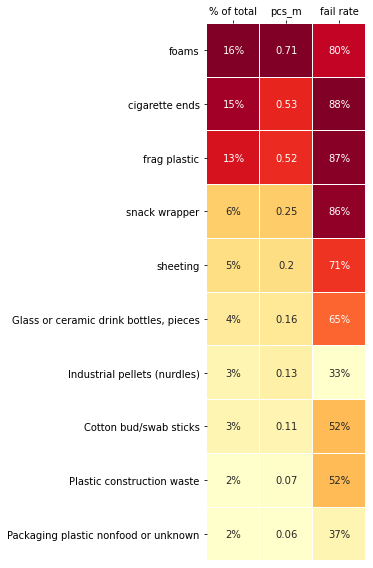

In [8]:
fig, axs = plt.subplots(1,3, figsize=(5.4,8))

sns.heatmap(pd.DataFrame(ftsx['% of total']), ax = axs[0], cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".0%", cbar=False)
sns.heatmap(pd.DataFrame(ftsx['pcs_m']), ax = axs[1], cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".2", yticklabels=False, cbar=False)
sns.heatmap(pd.DataFrame(ftsx['fail rate']), ax = axs[2], cmap='YlOrRd', linewidth=.01, linecolor='white', annot=True, square=True, fmt=".0%", yticklabels=False, cbar=False)

for i in [0,1,2]:
    axs[i].set_ylabel("")
    axs[i].set_xlabel("")
    axs[i].xaxis.tick_top()
    axs[i].xaxis.set_label_position('top') 

plt.tight_layout()

plt.show()
plt.close()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch